# Exploring FSTs for Token Alignment

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from arsenal import timeit
from IPython.display import HTML
from genparse import FST, Float, EarleyLM as CFGLM, MockLLM, locally_normalize, EOS
from genparse.proposal import TokenProposal
from genparse.util import LarkStuff, regex_to_greenery
from genparse.trace import TraceSWOR

WARNING 07-05 17:28:25 _custom_ops.py:14] Failed to import from vllm._C with ImportError('libcuda.so.1: cannot open shared object file: No such file or directory')


In [3]:
def bpe2term_approx(tokenizer, bpe_sequence):
    from genparse import FST, Float

    # approximate the transducer using a single canonical path;
    # UPDATE: the unpruned answer should match this - it's the uncertainty over bpe that's tricky
    c = tuple(
        ([b], tokenizer.convert_ids_to_tokens(b).replace('Ġ', ' ')) for b in bpe_sequence
    )
    tmp = FST.from_pairs([([], '')], Float)
    for pair in c:
        tmp = tmp * FST.from_pairs([pair], Float)
    return tmp
    # TODO: approximate this transducer by a canonical path
    # return c2t(c, None).trim.epsremove.trim

In [4]:
# was a method on LarkStuff
def lark_stuff_transducer(self, decay=0.99):
    from genparse import EPSILON, FST, Float

    m = FST(Float)
    START = 0
    STOP = 1
    m.add_I(START, 1)
    m.add_F(STOP, decay)
    m.add_arc(STOP, (EPSILON, EPSILON), START, 1)
    for token_id, token_class in enumerate(self.terminals):
        fsm = regex_to_greenery(token_class.pattern.to_regexp())
        m.add_arc(START, (EPSILON, token_class.name), (token_id, fsm.initial), 1)
        for final_state in fsm.finals:
            m.add_arc((token_id, final_state), (EPSILON, EPSILON), STOP, 1)
        dead = {i for i in fsm.states if not fsm.islive(i)}
        for state in fsm.states:
            arcs = fsm.map[state]
            for input_char, next_state in arcs.items():
                if next_state in dead:
                    continue
                for char in input_char.get_chars():
                    m.add_arc(
                        (token_id, state),
                        (char, EPSILON),
                        (token_id, next_state),
                        decay,
                    )
    return m

## Accounting for BPE's Tokenization Ambiguity with Transduction 

In [5]:
lark_stuff = LarkStuff(
    r"""
    start: NAME
    NAME: /(a|b)*c/
    """
)
foo = lark_stuff.char_cfg(decay=0.1)
foo = locally_normalize(foo)
assert len(foo.trim()) > 0

In [6]:
foo

Grammar {
  1.0: 0 → 1
  1.0: 1 → 2
  1.0: 3 → 
  0.03333333333333333: 2 → a 2
  0.03333333333333333: 2 → b 2
  0.9333333333576115: 2 → c 3
}

In [7]:
foo.cnf.language(3)

key,value
"('c',)",0.9333333333576115
"('b', 'c')",0.031111111111920383
"('b', 'b', 'c')",0.0010370370370640127
"('b', 'a', 'c')",0.0010370370370640127
"('a', 'c')",0.031111111111920383
"('a', 'b', 'c')",0.0010370370370640127
"('a', 'a', 'c')",0.0010370370370640127


In [8]:
lm = CFGLM(foo)

In [9]:
trace = TraceSWOR()
for t in range(15):
    with trace:
        print(t, lm.sample(draw=trace))

0 (('c',), 0.9333333333333406)
1 (('a', 'c'), 0.03111111111110799)
2 (('b', 'c'), 0.03111111111110799)
3 (('a', 'a', 'c'), 0.001037037037036821)
4 (('b', 'a', 'c'), 0.001037037037036821)
5 (('b', 'b', 'c'), 0.001037037037036821)
6 (('a', 'b', 'c'), 0.001037037037036821)
7 (('a', 'a', 'a', 'c'), 3.4567901234556977e-05)
8 (('b', 'a', 'a', 'c'), 3.4567901234556977e-05)
9 (('b', 'a', 'b', 'c'), 3.4567901234556977e-05)
10 (('b', 'b', 'a', 'c'), 3.4567901234556977e-05)
11 (('a', 'b', 'a', 'c'), 3.4567901234556977e-05)
12 (('a', 'a', 'b', 'c'), 3.4567901234556977e-05)
13 (('a', 'b', 'a', 'a', 'c'), 1.152263374485108e-06)
14 (('b', 'b', 'a', 'b', 'c'), 1.152263374485108e-06)


In [10]:
def about(m):
    print(len(m.states), 'states')

In [11]:
import transformers
from genparse.tokenization import decode_tokenizer_vocab
from genparse.segmentation import bpe_wfst

In [12]:
tokenizer = transformers.AutoTokenizer.from_pretrained('gpt2')
decode = decode_tokenizer_vocab(tokenizer)
T = bpe_wfst(enumerate(decode))
about(T)

98036 states


Let's shrink the BPE transducer down to something managable by limiting it alphabet 

In [13]:
# b2c = T.prune_to_alphabet(None, foo.V | {''}).renumber
# about(b2c)

In [14]:
b2c = T.prune_to_alphabet(None, foo.V | {''}).renumber

We can look at our little language's strings thru the lense of their possible BPE sequences.  Notice that these strings are ambiguously mapped to BPE --- meaning that there are many BPE sequences that would give rise to the same string!

('c',)
total weight of BPE sequences (i.e., ambiguity): 1.0


('b', 'c')
total weight of BPE sequences (i.e., ambiguity): 2.0


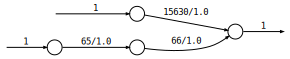

('b', 'b', 'c')
total weight of BPE sequences (i.e., ambiguity): 3.0


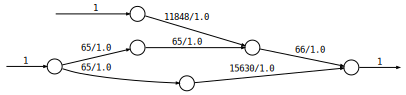

('b', 'a', 'c')
total weight of BPE sequences (i.e., ambiguity): 3.0


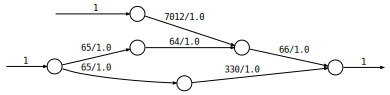

('a', 'c')
total weight of BPE sequences (i.e., ambiguity): 2.0


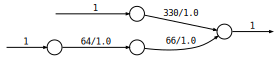

('a', 'b', 'c')
total weight of BPE sequences (i.e., ambiguity): 4.0


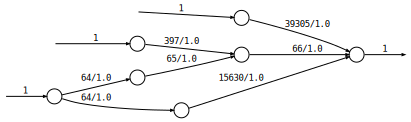

('a', 'a', 'c')
total weight of BPE sequences (i.e., ambiguity): 3.0


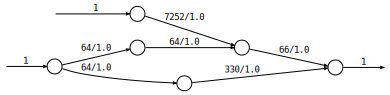

In [15]:
for x in foo.cnf.language(3):
    display(HTML('<hr/>'))
    print(x)
    bpe_x = b2c(None, x).epsremove.trim
    print('total weight of BPE sequences (i.e., ambiguity):', bpe_x.total_weight())
    display(bpe_x)
    print()

In [16]:
tmp = (b2c @ foo).trim()

In [17]:
L = 5

In [18]:
c = Float.chart()
for (
    x,
    w,
) in tmp.cnf.language(5).items():
    y = tokenizer.decode(x)
    if len(y) > L:
        continue
    c[y] += w

In [19]:
ambig = Float.chart({x: b2c(None, x).total_weight() for x in c})

In [20]:
ccc = Float.chart()
for x in c:
    ccc[x] = c[x] / ambig[x]

In [21]:
cc = Float.chart()
for x, w in foo.cnf.language(L + 2).items():
    if len(x) > L:
        continue
    cc[''.join(x)] += w
# cc

In [22]:
ccc.assert_equal(cc, tol=1e-20)

In [23]:
# cc.metric(c)

In [24]:
# tmp.trim(bottomup_only=True)

In [25]:
# show_grammar(tmp, showzero=True)

In [26]:
# print(tmp.agenda().__str__(style_value=lambda k, v: (colors.light.red % v) if v > 1.000001 or v < 0 else v))

In [27]:
# for q in c2t.states:
#    for (a,b), r, w in c2t.arcs(q):
#        print(f'--{a or "ε"}:{b or "ε"}/{w}-->', r)

In [28]:
# {x: v for x,v in tmp.agenda().items() if v > 1.001 or v < 0}

In [29]:
# len(tmp.N - tmp.agenda(tol=1e-40, maxiter=np.inf).trim().keys()), len(tmp.N), len(tmp.agenda(tol=1e-40).trim())

In [30]:
# tmp.cnf.language(4)

In [31]:
# show_grammar(tmp)

In [32]:
p = locally_normalize(tmp, tol=1e-40, maxiter=np.inf).trim()

In [33]:
lm2 = CFGLM(p.cnf)

In [34]:
# lm2.sample(verbose=1)

In [35]:
# context = (64,65,6485,39305)
context = (
    64,
    65,
    6485,
)

In [36]:
char_context = tokenizer.decode(context)
char_context

'ababb'

In [37]:
df = []
for x, w in sorted(lm2.p_next(context).normalize().items(), key=lambda kv: -kv[1]):
    df.append((x, (decode[x] if x != EOS else EOS), w))
pd.DataFrame(df, columns=['token_id', 'chars', 'prob']).set_index('token_id')

,chars,prob
token_id,,
48910,abba,0.419317
66,c,0.419316
6485,abb,0.064312
64,a,0.032139
65,b,0.032138
15630,bc,0.013977
330,ac,0.013977
7012,ba,0.001071
11848,bb,0.001071


In [38]:
lm.p_next(char_context).normalize()

key,value
a,0.03333333333332973
b,0.03333333333332973
c,0.9333333333333406


## Lexing

In [39]:
lark_stuff = LarkStuff(
    r"""
    start: "SELECT" WS STAR WS "FROM" WS NAME WS EOS
    EOS: "</s>"
    NAME: /[a-z]+/
    STAR: "*"
    WS: /[ ]/
    """
)

In [40]:
foo = lark_stuff.char_cfg(0.1)

In [41]:
# foo['NAME'].trim().agenda()

In [42]:
# foo.agenda()

In [43]:
foo = locally_normalize(foo, tol=1e-100).trim()
assert len(foo) > 0

In [44]:
# foo

In [45]:
lm = CFGLM(foo)

In [46]:
trace = TraceSWOR()
for _ in range(15):
    print('mass=', trace.root.mass)
    with trace:
        print(''.join(lm.sample(draw=trace, prob=False)))

mass= 1.0
SELECT * FROM m </s>
mass= 0.9652421652421627
SELECT * FROM r </s>
mass= 0.9304843304843258
SELECT * FROM e </s>
mass= 0.8957264957264889
SELECT * FROM d </s>
mass= 0.860968660968652
SELECT * FROM l </s>
mass= 0.8262108262108151
SELECT * FROM q </s>
mass= 0.7914529914529782
SELECT * FROM b </s>
mass= 0.7566951566951413
SELECT * FROM u </s>
mass= 0.7219373219373044
SELECT * FROM v </s>
mass= 0.6871794871794676
SELECT * FROM i </s>
mass= 0.6524216524216311
SELECT * FROM h </s>
mass= 0.6176638176637942
SELECT * FROM o </s>
mass= 0.5829059829059574
SELECT * FROM z </s>
mass= 0.5481481481481206
SELECT * FROM y </s>
mass= 0.5133903133902837
SELECT * FROM x </s>


In [47]:
cfg = lark_stuff.convert().renumber()

In [48]:
c2t = lark_stuff_transducer(lark_stuff, decay=0.0125)
len(c2t.states)

25

The `lark` library will only lex it one way because it has a deterministic semantics for prioritized lexing:

In [49]:
x = 'SELECT * FROM data'

In [50]:
list(lark_stuff.lex(x))

[Token('SELECT', 'SELECT'),
 Token('WS', ' '),
 Token('STAR', '*'),
 Token('WS', ' '),
 Token('FROM', 'FROM'),
 Token('WS', ' '),
 Token('NAME', 'data')]

However, this string can lex many different ways:

In [51]:
ambig = (
    (FST.from_string(x, Float) @ c2t)
    .trim.project(1)
    .epsremove.trim.to_cfg()
    .cnf.language(15)
)

In [52]:
# ambig

It might be fine to allow ambiguous lexing because very few of the possible lexing options will survive the parser.

In [53]:
for y in ambig:
    v = cfg.prefix_weight(y)  # show all options with a nonzero prefix weight
    if v == 0:
        continue
    print(v, y)

1.0 ('SELECT', 'WS', 'STAR', 'WS', 'FROM', 'WS', 'NAME')


In [54]:
# ((FST.from_string('SELECT', Float) @ c2t) @ P.T @ cfg).trim().cnf.language(15)

In [55]:
# (P.T @ cfg).trim().cnf.language(100)

In [56]:
cfg_t = (c2t.renumber @ cfg).trim()
pcfg_t = locally_normalize(cfg_t, tol=1e-100, maxiter=10_000_000)

In [57]:
cfg_t('SELECT * FROM data </s>')

2.1175823681357538e-46

In [58]:
cfg_t('SELECT * FROM data </s>')

2.1175823681357538e-46

In [59]:
lm = CFGLM(pcfg_t.cnf)

In [60]:
for _ in range(10):
    print(''.join(lm.sample(prob=False)))

SELECT * FROM b </s>
SELECT * FROM d </s>
SELECT * FROM u </s>
SELECT * FROM e </s>
SELECT * FROM n </s>
SELECT * FROM ujy </s>
SELECT * FROM t </s>
SELECT * FROM tl </s>
SELECT * FROM t </s>
SELECT * FROM k </s>


In [61]:
lm.p_next('SELECT * FROM ')

key,value
u,0.03846153846151434
v,0.03846153846151434
b,0.03846153846151434
y,0.03846153846151434
k,0.03846153846151434
j,0.03846153846151434
x,0.03846153846151434
f,0.03846153846151434
o,0.03846153846151434
w,0.03846153846151434


## BPE Basics

In [62]:
b2c = T
len(b2c.states)

98036

In [63]:
x = 'SELECT * FROM data'
b = tokenizer.encode(x)
b

[46506, 1635, 16034, 1366]

In [64]:
[tokenizer.decode(bb) for bb in b]

['SELECT', ' *', ' FROM', ' data']

In [65]:
with timeit('composition'):
    c = FST.from_string(tuple(b), Float) @ b2c
about(c)

490180 states


composition (19.8336 sec)


In [66]:
c.trim

We can build this "transducer" more efficiently

In [67]:
t = bpe2term_approx(tokenizer, tokenizer.encode(x)).epsremove.trim
t

## BPE Ambiguity

In [68]:
x = x = 'SELECT * FROM data'

In [69]:
with timeit('composition'):
    bs = b2c @ FST.from_string(x, Float)
with timeit('trim'):
    bs.trim
about(bs)

68 states


composition (6.0894 sec)
trim (0.0063 sec)


In [70]:
# bs.trim

The automaton below describes all the BPE sequences that generate the string `x` and the number below is the total weight of these paths (in the count semiring these are the number of distinct paths):

In [71]:
bs.trim.project(0).epsremove.trim.total_weight()

7904.0

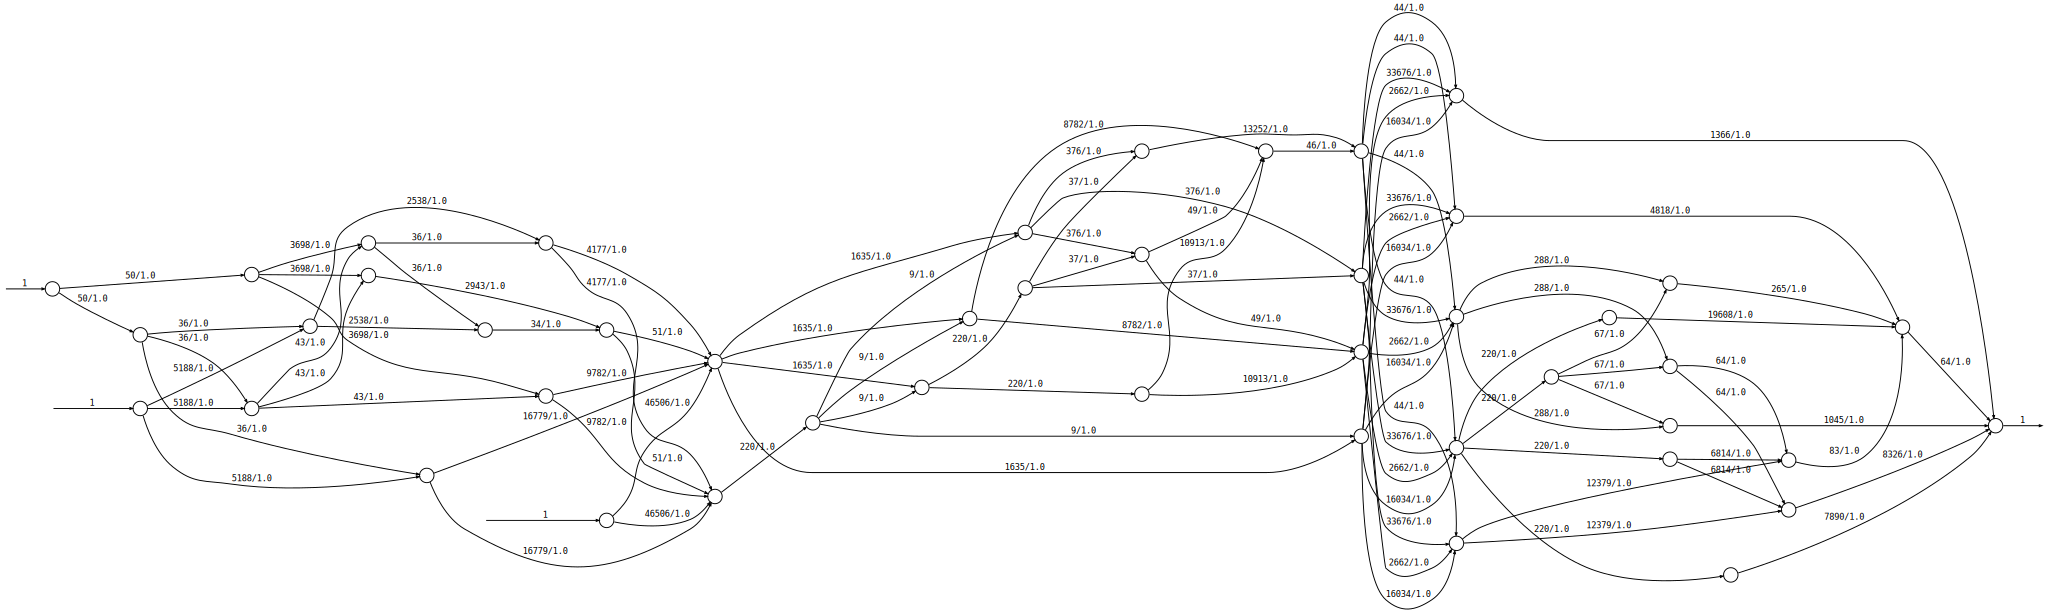

In [72]:
bs.trim.project(0).epsremove.trim

To see all the BPE sequences that generate `x` run the cell below:

In [73]:
# for y in bs.trim.project(0).epsremove.trim.to_cfg().language(10):
#    print(tokenizer.decode(y), y)

## The Grafting Heuristic

In [74]:
lark_stuff = LarkStuff(
    r"""
start: "SELECT" WS select_expr WS "FROM" WS from_expr [WS "WHERE" WS bool_condition] [WS "GROUP BY" WS var_list] [WS "ORDER BY" WS orderby_expr] WS EOS
EOS: "</s>"
select_expr: STAR | select_list
bool_condition: bool_expr | "(" bool_condition WS "AND" WS bool_condition ")" | "(" bool_condition WS "OR" WS bool_condition ")"
bool_expr: var "=" value | var ">" value | var "<" value
from_expr: "data"
orderby_expr: var_list WS "ASC" | var_list WS "DESC"
select_list: select_var ("," WS select_var)*
var_list: var ("," WS var)*
select_var: var | "AVG(" var ")" | "MEDIAN(" var ")" | "COUNT(" var ")"
var: "age" | "gender" | "year" | "state_color" | "zipcode" | "vote" | "race_ethnicity"
value: NUMBER | "red" | "blue" | "white" | "black" | "latino" | "republican" | "democrat" | "male" | "female"
STAR: "*"
NUMBER: /\d+/
WS: " "
"""
)

foo = lark_stuff.char_cfg(0.7)
foo = locally_normalize(foo, tol=1e-100).trim()
assert len(foo) > 0
lm = CFGLM(foo)

In [75]:
print(''.join(lm.sample(prob=False)))

SELECT * FROM data </s>


In [76]:
bpe_lm = TokenProposal(
    guide=lm, llm=MockLLM(V={x for x in decode}, eos=tokenizer.eos_token)
)

In [77]:
lm.p_next('')

key,value
S,0.9999999999999999


In [78]:
bpe_lm._prompt = ()
bpe_lm._p_next(())

key,value
S,0.3333333333333334
SE,0.3333333333333334
SELECT,0.33333333333333326


In [79]:
lm.p_next('SELECT')

key,value
,0.9999999999999999


In [80]:
bpe_lm._p_next(('SELECT',))

key,value
,0.49996004656530363
*,0.48495822525996535
a,0.004258827777178765
y,0.0029811794440251344
v,0.0029811794440251344
g,0.0014607779275723162
A,0.0010734251371373343
z,0.001022544549300621
C,0.0005259783171972939
M,0.00036818482203810563


In [81]:
ys = bpe_lm.sample()
ys

(('SE',
  'L',
  'E',
  'C',
  'T',
  ' ',
  '*',
  ' FROM',
  ' da',
  't',
  'a',
  ' ',
  '</',
  's',
  '>'),
 3.591811896045763e-05)